In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("housing.data")
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


    crim - per capita crime rate by town
    zn - proportion of residential land zoned for lots over 25,000 sq.ft
    indus - proportion of non-retail business acres per town
    chas - Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
    nox - nitric oxides concentration (parts per 10 million)
    rm - average number of rooms per dwelling
    age - proportion of owner-occupied units built prior to 1940
    dis - weighted distances to five Boston employment centres
    rad - index of accessibility to radial highways
    tax - full-value property-tax rate per USD 10,000
    ptratio- pupil-teacher ratio by town
    b 1000(B - 0.63)^2, where B is the proportion of blacks by town
    lstat - percentage of lower status of the population
    medv - median value of owner-occupied homes in USD 1000’s

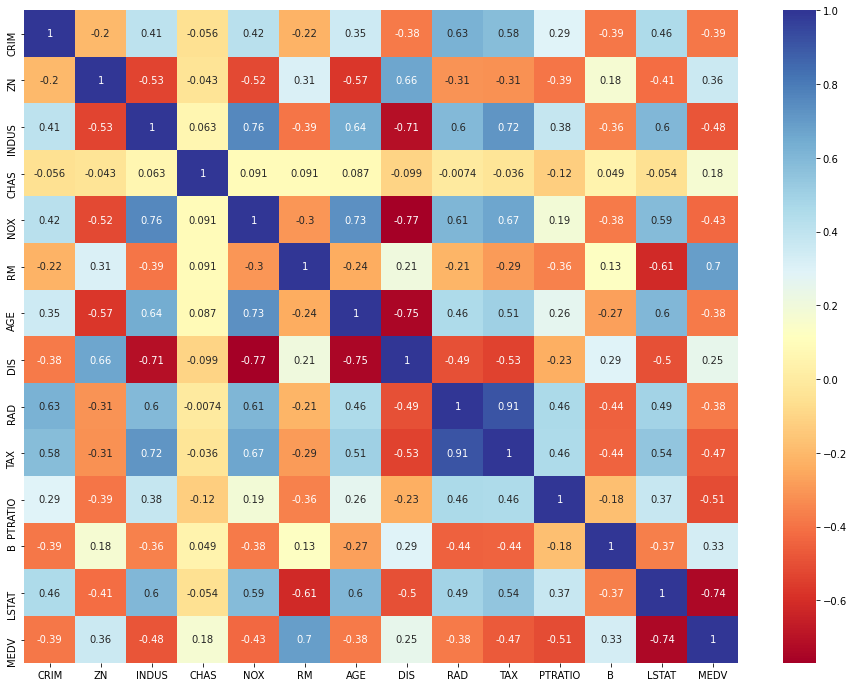

In [47]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
sns.heatmap(df.corr(),cmap='RdYlBu',annot=True);

    LSTAT - процент бедных
    INDUS - процент земель занятых предприятиями
    NOX - загрязнённость местности
    RM - среднее количество комнат в доме
    MEDV - медианная стоимость цен на дома жильцов  

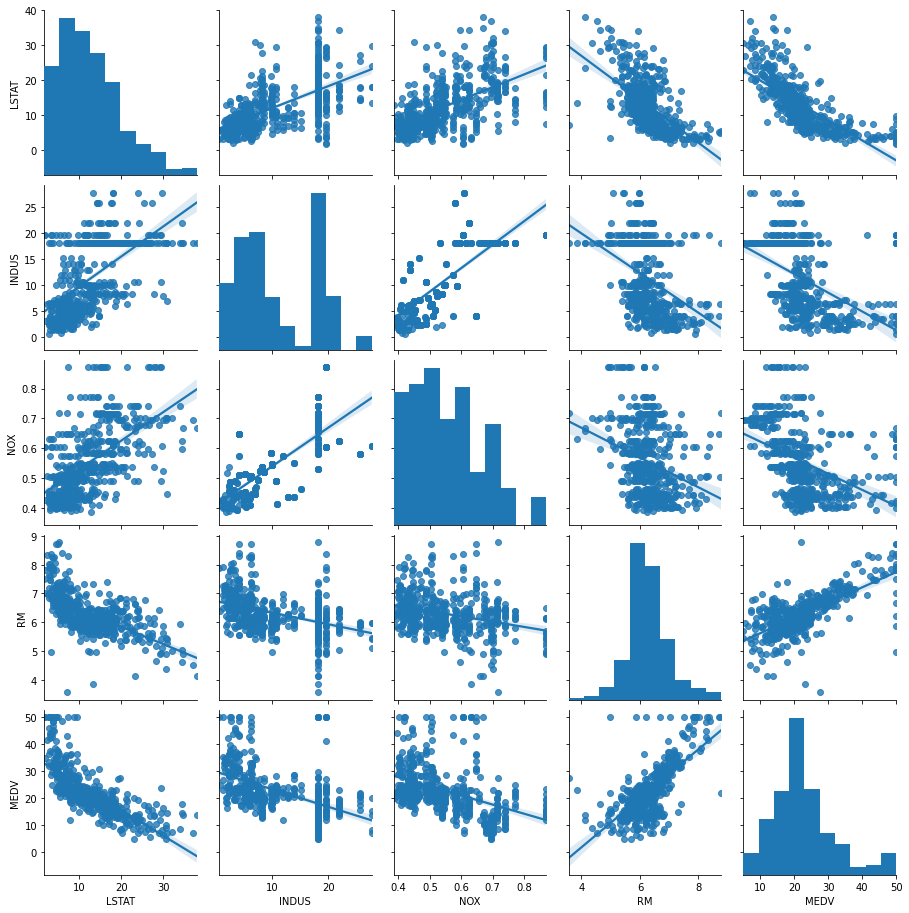

In [48]:
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], kind="reg");

- Предполагается линейная взаимосвязь между количеством квартир **RM** и ценами на дома **MEDV**
- Переменные **RM, MEDV** имеют нормальное распределение


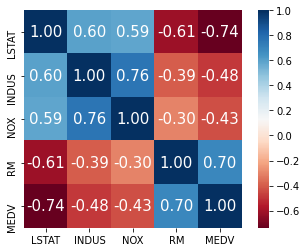

In [49]:
cm = np.corrcoef(df[cols].values.T)
sns.heatmap(cm,cmap='RdBu', cbar=True,
            annot=True,square=True,
            fmt='.2f',annot_kws={'size': 15},
            yticklabels=cols,xticklabels=cols);

### Прогнозирование непрерывных целевых переменных с помощью регрессионного анализа

In [50]:
class LinearRegressionGD(object):
    """
    eta (float)
         скорость обучения
    n_iter (int)
         проходы по обучающимся наборам данных
    w_ (ld-array)
         Веса после прогонки
    cost_ (list)
        сумма квадратичных ошибок, показывающие успешность алгоритма
    """

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        """
        X (matrix) обучающие векторы, shape = [примеры, переменные]
        y (vector)  целевые значения (1|-1)
        :return self
        """

        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)  # отклонения расчетных результатов от истинных меток классов
            self.w_[1:] += self.eta * X.T @ errors  # обновляем веса, вычислив градиент
            self.w_[0] += self.eta * errors.sum()
            cost = (errors ** 2).sum() / 2
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """  вычисляет общий вход """
        return X @ self.w_[1:] + self.w_[0]


    def predict(self, X):
        """ возращает метку класса после единичного шага"""
        return self.net_input(X)


In [51]:
from sklearn.preprocessing import StandardScaler
X = df[['RM']].values
y = df['MEDV'].values

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

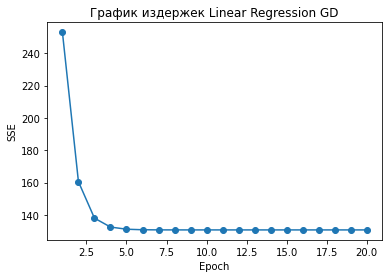

In [52]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

plt.plot(range(1, lr.n_iter+1), lr.cost_, marker='o')
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.title('График издержек Linear Regression GD');

In [53]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)    

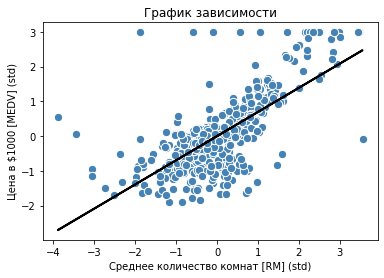

In [54]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Среднее количество комнат [RM] (std)')
plt.ylabel('Цена в $1000 [MEDV] (std)')
plt.title('График зависимости');

In [55]:
num_rooms_std = sc_x.transform(np.array([[6]]))
price_std = lr.predict(num_rooms_std)
price = sc_y.inverse_transform(price_std)*1000
print("Цена на 6-этажый дом ~%.0f$"% price)

Цена на 6-этажый дом ~19942$


### Оценка коэффициента регрессионной модели с помощью scikit-learn

In [56]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)

print('𝑦̂ = 𝑖𝑛𝑡𝑒𝑟𝑐𝑒𝑝𝑡+𝑠𝑙𝑜𝑝𝑒*x')
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

𝑦̂ = 𝑖𝑛𝑡𝑒𝑟𝑐𝑒𝑝𝑡+𝑠𝑙𝑜𝑝𝑒*x
Slope: 9.102
Intercept: -34.671


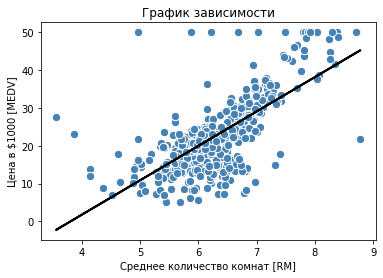

In [57]:
lin_regplot(X, y, slr)
plt.xlabel('Среднее количество комнат [RM]')
plt.ylabel('Цена в $1000 [MEDV]')
plt.title('График зависимости');

### Подгонка надежной регрессионной модели с использованием RANSAC
согласие на основе случайных выборок ***(Random Sample Consensum)***
<br>**Идея:** подогнать модель к поднабору данных (**не-выбросам**) 
>**Алгоритм:**
1. Случайно выбрать образцы, которые **не-выбросы**, обучить модель 
2. Проверить все образцы на модели и потом добавить оставшиеся образцы (**не-выбросы**)
3. Повторно обучить модель на не-выбросах и оценить SSE.

In [58]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, 
                         min_samples=50, 
                         loss='absolute_loss',   # абсолютное расстояние по вертикали
                         residual_threshold= 5,  # расстояние до прямой, отсекающее выбросы 
                         random_state=0)
ransac.fit(X, y);

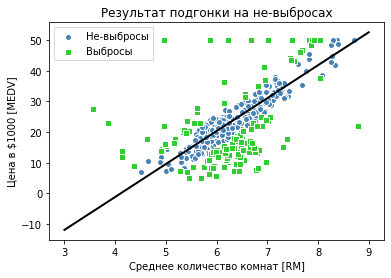

In [59]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white', 
            marker='o', label='Не-выбросы')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Выбросы')

plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.xlabel('Среднее количество комнат [RM]')
plt.ylabel('Цена в $1000 [MEDV]')
plt.title('Результат подгонки на не-выбросах');
plt.legend(loc='upper left');

### Оценка эффективности моделей линейной регрессии

In [60]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [61]:
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

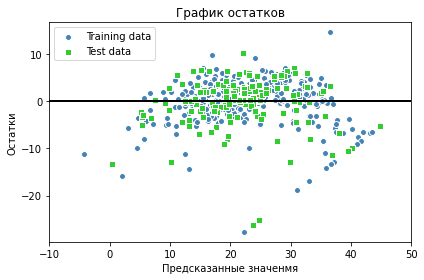

In [62]:
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')

plt.xlabel('Предсказанные значенмя')
plt.ylabel('Остатки')
plt.title('График остатков')
plt.legend(loc='best')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.tight_layout()

### - Mean SSE [MSE]
* нормализует SSE по размеру выборки

In [63]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196
R^2 train: 0.765, test: 0.673


**Вывод:** смотрим на MSE -: модель переобучена

# Регуляризационные методы для регрессии

## Гребневая регрессия *Ridge Regression*
-штрафуемая методом **L2** модель

In [64]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)

## *LASSO*
регрессия методом абсолютного сокращения и выбора
<br>*Least Absolute Shrinkage and Selection Operator*

-штрафуемая методом **L1** модель

In [65]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)

<img src='https://user-images.githubusercontent.com/54672403/82748979-c862a600-9dae-11ea-8960-202a5e47df83.png' width='500'>
<img src='https://user-images.githubusercontent.com/54672403/82749025-0f509b80-9daf-11ea-82b2-6ade494c5cb2.png' width='500'>

In [66]:
from sklearn.linear_model import ElasticNet
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5) # через l1_ratio можно регулировать соотношение L1 к L2

# Криволинейно-полиномиальная регрессия
${\displaystyle y=w _{0}+w _{1}x+w _{2}x^{2}+w _{3}x^{3}+\cdots +w _{n}x^{n}}$
<br>n - стерень полинома

In [67]:
from sklearn.preprocessing import PolynomialFeatures
X = np.array([258, 270, 294, 
              320, 342, 368, 
              396, 446, 480, 586])[:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368, 391.2, 390.8])

lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2) # добавление полиномиального члена 2-степени
X_quad = quadratic.fit_transform(X)

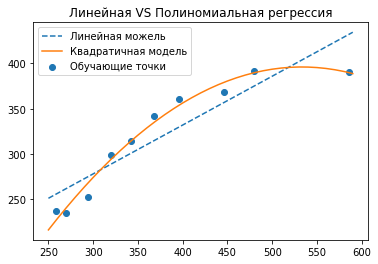

In [68]:
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

plt.scatter(X, y, label='Обучающие точки')
plt.plot(X_fit, y_lin_fit, label='Линейная можель', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='Квадратичная модель')
plt.legend(loc='best')
plt.title('Линейная VS Полиномиальная регрессия');

In [69]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print('Training MSE linear: %.3f,\t quadratic: %.3f' % (
        mean_squared_error(y, y_lin_pred),
        mean_squared_error(y, y_quad_pred)))
print('Training R^2 linear: %.3f,\t quadratic: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred)))

Training MSE linear: 569.780,	 quadratic: 61.330
Training R^2 linear: 0.832,	 quadratic: 0.982


## Моделирование нелинейных взаимосвязей
    LSTAT - процент бедных
    MEDV - цены на дом

In [70]:
X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)

X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

In [71]:
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

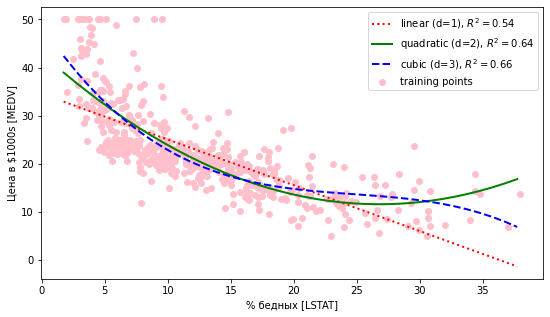

In [72]:
plt.figure(figsize=(9,5))
plt.scatter(X, y, label='training points', color='pink')

plt.plot(X_fit, y_lin_fit, 
         label=f'linear (d=1), $R^2={linear_r2:.2}$',
         color='red', lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label=f'quadratic (d=2), $R^2={quadratic_r2:.2}$',
         color='green', lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label=f'cubic (d=3), $R^2={cubic_r2:.2}$',
         color='blue', lw=2, 
         linestyle='--')

plt.xlabel('% бедных [LSTAT]')
plt.ylabel('Цена в $1000s [MEDV]')
plt.legend(loc='best');

In [73]:
import plotly.graph_objects as go
# plotly figure setup
fig=go.Figure()
fig.add_trace(go.Scatter(x=X.flatten(), y=y, mode='markers', marker_color='pink'))
fig.add_trace(go.Scatter(x=X_fit.flatten(), y=y_lin_fit.flatten(),
                        name=f'$linear (d=1), R^2={linear_r2:.2}$', mode='lines'))

fig.add_trace(go.Scatter(x=X_fit.flatten(), y=y_quad_fit.flatten(),
                        name=f'$quadratic (d=2), R^2={quadratic_r2:.2}$', mode='lines'))

fig.add_trace(go.Scatter(x=X_fit.flatten(), y=y_cubic_fit.flatten(),
                        name=f'$cubic (d=3), R^2={cubic_r2:.2}$', mode='lines'))

# plotly figure layout
fig.update_layout(xaxis_title = '% бедных [LSTAT]', yaxis_title = 'Цена в $1000 [MEDV]')

> - Связь между 2 переменными похожа на экспоненциальную функцию 
$ f(x)=2^{-x}$
> - логорифм экспоненциальной функции - линия 
$ \log{f(x)}= -x$


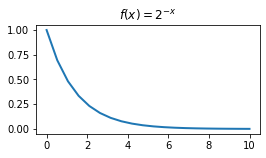

In [74]:
import numpy as np
plt.figure(figsize=(4,2))
x = np.linspace(0, 10, 20)
plt.plot(x, np.exp2(-x), lw=2,);
plt.title('$ f(x)=2^{-x}$');

In [75]:
# трансформирование признаков
X_log = np.log(X)
y_sqrt = np.sqrt(y)

# обучение
X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]

regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

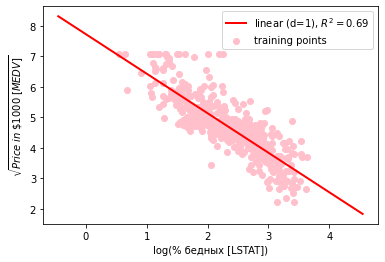

In [76]:
plt.scatter(X_log, y_sqrt, label='training points', color='pink')

plt.plot(X_fit, y_lin_fit, 
         label=f'linear (d=1), $R^2={linear_r2:.2}$',
         color='red', lw=2)

plt.xlabel('log(% бедных [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000 \; [MEDV]}$')
plt.legend(loc='best');

# Регрессия на основе дерева принятий решений
- критерий разделения **MSE** - понижение дисперсии

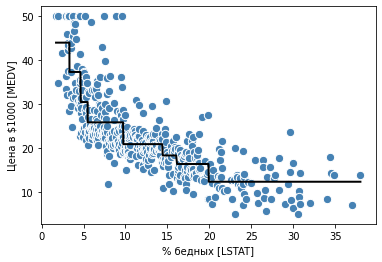

In [77]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% бедных [LSTAT]')
plt.ylabel('Цена в $1000 [MEDV]');

# Регрессия на основе случайного леса

In [78]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [85]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000, criterion='mse', 
                               random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.2f\t test: %.2f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f\t test: %.2f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 2.15	 test: 10.62
R^2 train: 0.98	 test: 0.86


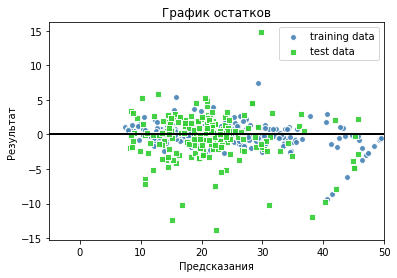

In [94]:
plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='steelblue', edgecolor='white',
            marker='o', s=35, alpha=0.9, 
            label='training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='limegreen', edgecolor='white',
            marker='s', s=35, alpha=0.9,
            label='test data')

plt.hlines(y=0, xmin=-5, xmax=50, lw=2, color='black')
plt.xlim([-5, 50])


plt.xlabel('Предсказания')
plt.ylabel('Результат')
plt.legend(loc='best')
plt.title('График остатков');